<a href="https://colab.research.google.com/github/lewtun/fri-ml/blob/master/fastai-tabular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applying fast.ai to Tabular Data

_Summary:_ In this notebook we examine how fast.ai's [Tabular API](https://docs.fast.ai/tabular.html) can be used to train deep neural networks on tabular data. To keep things simple, we will look at Kaggle's [Titanic dataset](https://www.kaggle.com/c/titanic/overview) which is nowadays the "hello world" of classification tasks. 

_Sources:_

* lesson 4 from the fast.ai MOOC
* [An Introduction to Deep Learning for Tabular Data](https://www.fast.ai/2018/04/29/categorical-embeddings/)
* [Entity Embeddings of Categorical Variables](https://arxiv.org/pdf/1604.06737.pdf)

_Created by:_ Lewis Tunstall, Summer 2019


## Load libraries

In [1]:
# this step is necessary to setup fast.ai in Google collab
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [2]:
from google.colab import drive

# data viz
import seaborn as sns

# ml magic
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# fastai fun
from fastai.tabular import *
from fastai.callbacks import SaveModelCallback
import fastai
print(f'fast.ai version: {fastai.__version__}')

fast.ai version: 1.0.55


## Mount Google Drive
In order to persist our datasets and avoid manually uploading them each session, the following snippet mounts your Google Drive directory to the Collab environment. 

**Note:** I store all my datasets on Google Drive in a `data/` directory. If you store them elsewhere, you should change the `base_dir` variable below accordingly.

In [3]:
drive.mount('/content/gdrive', force_remount=True)
root_dir = '/content/gdrive/My Drive/'
# change data/ to the relevant location on your gDrive
base_dir = root_dir + 'data/'

Mounted at /content/gdrive


Next we need to define the path for our `DataBunch` and `Learner` objects. First download the `train.csv` and `test.csv` files from [Kaggle](https://www.kaggle.com/c/titanic/data) and store them in a directory on your gDrive, e.g. `kaggle_titanic/`:

In [0]:
# change kaggle_titanic/ to the relevant path on your gDrive
path = Path(base_dir + 'kaggle_titanic/')

## Load and explore data
Let's load the Titanic dataset and take a quick look at the data structure:

In [5]:
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')

# show first five rows
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_df.shape

(891, 12)

There are 12 attributes, so let's get a quick description of each one's type and number of non-null values:

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Evidently the `Age` and `Cabin` attributes are the ones with the most missing values; fortunately fast.ai can automatically impute them for us in the preprocessing step below.

Finally let's have a lok at how the survival rates are distributed:

In [8]:
train_df['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

Unsurprisingly for a real-world dataset we have a moderate amount of class imbalance, with the majority of passengers not surviving. 

## Prepare the data
As explained in the fast.ai [docs](https://docs.fast.ai/tabular.html#Preprocessing-tabular-data), the first thing we need to prepare our data as a `DataBunch` object. The general steps are as follows:

1. Define the target variable
2. Define the names of the categorical and continuous features
3. Define the preprocessing `Transforms`, e.g. convert Pandas `object` data types to `category`, normalise continuous variables etc.

Let's apply these steps to the case at hand:

In [0]:
# define a pandas.Series object of test IDs for later use
test_id = test_df['PassengerId']
# TabularList complains if a feature has NaNs in the test set, but not in the 
# train set. 
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)

In [10]:
# name of the target variable
dep_var = 'Survived'

# names of categorical features
cat_names = [ 'Sex', 'Ticket', 'Cabin', 'Embarked']

# names of numerical features
cont_names = [ 'Age', 'SibSp', 'Parch', 'Fare']

# define transformations
procs = [FillMissing, Categorify, Normalize]

# create test tabularlist
test = TabularList.from_df(test_df, cat_names=cat_names, cont_names=cont_names, procs=procs)

# create train databunch
data = (
    TabularList.from_df(train_df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                        .split_by_rand_pct(0.1, seed=42)  # create train / validation split
                        .label_from_df(cols = dep_var)    # define label of target
                        .add_test(test, label=0)          # include test set
                        .databunch()                      # convert to DataBunch
)

# view sample
data.show_batch(rows=10)

Sex,Ticket,Cabin,Embarked,Age_na,Age,SibSp,Parch,Fare,target
female,315153,#na#,S,False,-1.9448,-0.4703,2.0164,-0.2003,1
male,SC/Paris 2123,#na#,C,False,-0.3366,0.4151,2.0164,0.1888,0
male,349210,#na#,S,False,0.5058,-0.4703,-0.4658,-0.4895,0
male,315089,#na#,S,False,0.6590,-0.4703,-0.4658,-0.4662,0
male,237798,#na#,S,False,0.9653,-0.4703,-0.4658,-0.3799,1
male,349912,#na#,S,False,-0.8726,-0.4703,-0.4658,-0.4839,0
male,349247,#na#,S,False,0.5058,-0.4703,-0.4658,-0.4815,0
male,363291,#na#,S,False,-1.5619,-0.4703,2.0164,-0.2302,1
male,16988,D45,S,True,-0.1068,-0.4703,-0.4658,-0.0416,1
male,315097,#na#,S,False,-0.6429,-0.4703,-0.4658,-0.4662,0


Now that we have our data ready in a `DataBunch`, let's look at training some models.

## Train baseline models
Here we don't do anything fancy since the goal is to train a few quick and dirty models that can be used to benchmark the performance of our fast.ai classifier. Since we are dealing with a binary class problem, I've selected two simple classifiers:

* Random Forest
* Logistic regression

Random forests are great because the model architecture reduces overfitting, while logistic regression is a good choice to evaluate whether the dataset is linearly separable or not.

As shown [here](https://gist.github.com/dienhoa/a5adf923bd8b24b3d0eadcd61aec8c2e), one neat aspect of the fast.ai `Dataset` objects is that they can be used to create training and validation sets for other algorithms. The trick is to reconstruct the feature matrix $X$ and target vector $y$ in a form amenable for scikit-learn, i.e. as numpy arrays. The function below achieves this for us:

In [0]:
def get_arrays(ds):
    X_cats, X_conts = ds.x.codes, ds.x.conts
    y = ds.y.items
    return np.concatenate((X_cats, X_conts), axis=1), y

In [12]:
X_train, y_train = get_arrays(data.train_ds)
X_val, y_val = get_arrays(data.valid_ds)

X_train.shape, X_val.shape

((802, 9), (89, 9))

In [0]:
def fit_classifiers(classifiers, X_train, X_val, y_train, y_val):
    '''
    A utility function to calculate the accuracy of classifiers on the training set.
    '''

    for clf in classifiers:
        clf.fit(X_train, y_train)
        print(f'{clf.__class__.__name__}: {clf.score(X_val, y_val):.4f}')

In [14]:
# initialise classifiers
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
log_clf = LogisticRegression(solver='liblinear')

# concatenate and train
clf_list = [rf_clf, log_clf]
fit_classifiers(clf_list, X_train, X_val, y_train, y_val)

RandomForestClassifier: 0.8202
LogisticRegression: 0.8315


In practice, one would use some form of cross-validation and metrics like the ROC AUC, but for our purposes the above analysis is sufficient for now. Next, let's see if we can beat these baseline models with a DNN!

## Train a DNN model
As in other core applications of the fast.ai library, the general procedure to train a deep learning model is as follows:

1. Define a `Learner` object. In our case we can make use of the factory method `tabular_learner`.
2. Find the optimal learning rate using the learning rate finder.
3. Fit the model and evaluate the results.

One special aspect of `tabular_learner` is that we need to specify the number of hidden layers and their neurons in the `layers` argument. There are several "rules of thumb" that are discussed when choosing these parameters in a feed forward network (see e.g. [here](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw)), with the general advice:

* One hidden layer is sufficient for the large majority of problems. (Although this arguably applies more to MLP models)
* Take the number of neurons to be the size of the input layer and increase until overfitting.

A quick way to figure out the size of the input and output layers is to create a dummy `Learner` with an empty array in the `layer` argument (I got this idea from the fast.ai [forums](https://forums.fast.ai/t/how-to-define-the-good-neurals-and-layers-using-tabular/44583)):

In [15]:
learn_dummy = tabular_learner(data, layers = list())
learn_dummy.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(625, 59)
    (2): Embedding(133, 25)
    (3): Embedding(4, 3)
    (4): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0)
  (bn_cont): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=97, out_features=2, bias=True)
  )
)

By inspecting the linear layer we see that we have 97 input features and 2 output features, which makes sense since we only have two classes to consider. (For regression the number of output features is 1.). I began by defining `layers = [100, 50]` and experimented with different sizes that gave the best accuracy on the validation set. (A more systematic approach would be grid search + cross validation.)

**Note:** It appears that the rule of thumb to determine the optimal learning rate is less robust in tabular applications vs vision. I had to adopt a learning rate about 2 orders of magnitude less than the one suggested by the finder!

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-02
Min loss divided by 10: 3.31E-01


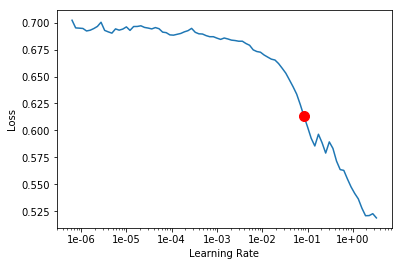

In [16]:
# create deep learning model
learn = tabular_learner(data, layers = [400, 2], emb_drop=0.04, ps=[0.001, 0.01], metrics=accuracy, callback_fns=ShowGraph)

# select the appropriate learning rate
learn.lr_find()

# look for point where the slope is steepest
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.680636,0.700839,0.595506,00:00
1,0.668026,0.685758,0.595506,00:00
2,0.644857,0.658835,0.595506,00:00
3,0.613138,0.605614,0.595506,00:00
4,0.570812,0.541694,0.786517,00:00
5,0.525864,0.505311,0.842697,00:00
6,0.482909,0.487568,0.831461,00:00
7,0.445432,0.476542,0.842697,00:00
8,0.415776,0.471440,0.842697,00:00
9,0.392817,0.471157,0.842697,00:00


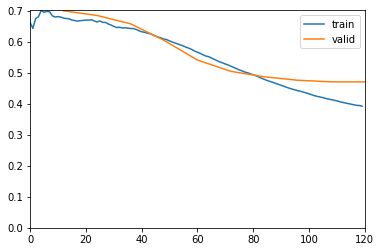

Better model found at epoch 0 with accuracy value: 0.5955055952072144.
Better model found at epoch 4 with accuracy value: 0.7865168452262878.
Better model found at epoch 5 with accuracy value: 0.8426966071128845.


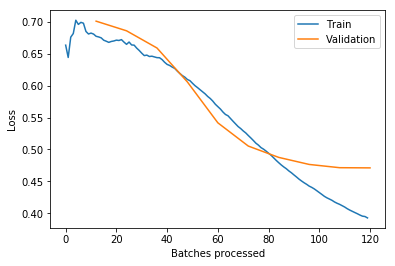

In [17]:
# fit the model and save best one during training
learn.fit_one_cycle(10, max_lr=slice(4e-3), callbacks=[SaveModelCallback(learn, every='improvement', mode='max', monitor='accuracy')])

# analyse the model
learn.recorder.plot_losses()

Evidentyl we have gained a boost of a few percent in accuracy compared to our baseline models. With more fine-tuning and other techniques like feature engineering and cross validation, higher scores should be possible.

## Generate predictions and Kaggle submission
Once we have a trained model, the final step is to generate predictions on the test set and submit to Kaggle! 

In [0]:
# get the model with highest accuracy
learn.load('bestmodel');

In [19]:
# predict our target value
preds, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(preds, 1)

# create submission file to submit to Kaggle
submission = pd.DataFrame({'PassengerId': test_id, 'Survived': labels})
submission.to_csv(path/'submission.csv', index=False)
submission.head()


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
